## Load Data

In [1]:
# Load Train and Test data
import os
import time
import torch
import numpy as np
from tqdm import tqdm

datadir = "/home/ucaptp0/oasis-rt-surrogate/data/preprocessed_data/rnn_sw/dynamical"

train_x = torch.load(os.path.join(datadir, "train_x.pt"))
train_y = torch.load(os.path.join(datadir, "train_y.pt"))
test_x = torch.load(os.path.join(datadir, "test_x.pt"))
test_y = torch.load(os.path.join(datadir, "test_y.pt"))

test_cosz = torch.load(os.path.join(datadir, "test_cosz.pt"))
test_cosz = test_cosz.numpy()
train_cosz = torch.load(os.path.join(datadir, "train_cosz.pt"))
train_cosz = train_cosz.numpy()

train_x = train_x.numpy()
train_y = train_y.numpy()
test_x = test_x.numpy()
test_y = test_y.numpy()

train_aux_x = torch.load(os.path.join(datadir, "train_aux_x.pt"))
test_aux_x = torch.load(os.path.join(datadir, "test_aux_x.pt"))

# Load altitudes 
altitude = np.load("/home/ucaptp0/oasis-rt-surrogate/data/grid/altitude.npy")
altitudeh = np.load("/home/ucaptp0/oasis-rt-surrogate/data/grid/altitudeh.npy")

In [ ]:
num_samples = 50000

print("Shape test_x: ", test_x.shape)

sample_test_x = test_x[:num_samples, :, :]
sample_test_aux_x = test_aux_x[:num_samples, :]
sample_test_y = test_y[:num_samples, :, :]

In [3]:
from utils import *
from models import *
from metrics import *
from main import postprocess_predictions, M_SW, C_SW

## **Extreme Learning Machine**

### Define Train, Test and Validation Sets

In [6]:
Xtest_ELM = Xtest[10000:, :]
ytest_ELM = ytest[10000:, :]

test_cosz_ELM = test_cosz[10000:]

val_x = train_x[-500001:-1, :, :].reshape(500000, 49*3)
val_y = train_y[-500001:-1, :, :]

num_test_samples = ytest_ELM.shape[0]
num_val_samples = val_x.shape[0]

Xtest_ELM shape: (758000, 147)
ytest_ELM shape: (758000, 50, 2)


### Grid Performance Analysis

In [ ]:
# Define path where to save results
ELM_savepath = "/home/ucaptp0/oasis-rt-surrogate/ELM_outputs/"

# Choose parameters for grid search and save these
number_training_examples = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
number_neurons = [100, 110, 120, 130, 140, 150, 175, 200, 225, 250, 300, 400, 500, 600, 700, 800, 1000]

with open(os.path.join(ELM_savepath, 'params.txt'), 'w') as f:
    f.write(f"number_training_examples: {number_training_examples}")
    f.write(f"\nnumber_neurons: {number_neurons}")

# Initialise results arrays
grid_losses = np.zeros(shape=(3, len(number_training_examples), len(number_neurons)))
grid_mae = np.zeros(shape=(len(number_training_examples), len(number_neurons), 50, 2))
grid_vae = np.zeros(shape=(len(number_training_examples), len(number_neurons), 50, 2))

# Specify dimensions of model inputs and outputs
input_size = 49 * 3
output_size = 50 * 2

# Perform grid search
for i in range(len(number_training_examples)):
    num_train_samples = number_training_examples[i]
    print("Number of training examples: ", num_train_samples)
    for j in tqdm(range(len(number_neurons))):
        hidden_size = number_neurons[j]

        X_ = train_x[:num_train_samples, :, :].reshape(num_train_samples, 49 * 3)
        y_ = train_y[:num_train_samples, :, :].reshape(num_train_samples, 50 * 2)
        
        elm = ELM(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            activation_function="relu"
        )
        training_start_time = time.time()
        elm.fit(X_, y_)
        training_end_time = time.time()

        prediction_start_time = time.time()
        ypred_ = elm.predict(val_x)
        prediction_end_time = time.time()

        ypred_ = ypred_.reshape((num_val_samples, 50, 2))
        mae, vae, loss = metrics(ypred_, val_y)

        grid_losses[0, i, j] = training_end_time - training_start_time
        grid_losses[1, i, j] = prediction_end_time - prediction_start_time
        grid_losses[2, i, j] = loss

        grid_mae[i, j, :, :] = mae
        grid_vae[i, j, :, :] = vae

# Save results of grid search
with open(os.path.join(ELM_savepath, 'grid_mae.npy'), 'wb') as f:
    np.save(f, grid_mae)
with open(os.path.join(ELM_savepath, 'grid_vae.npy'), 'wb') as f:
    np.save(f, grid_vae)
with open(os.path.join(ELM_savepath, 'grid_losses.npy'), 'wb') as f:
    np.save(f, grid_losses)

### Train Grid-Optimised Predictor

In [21]:
# Load results from file if needed

ELM_savepath = "/home/ucaptp0/oasis-rt-surrogate/ELM_outputs"

with open(os.path.join(ELM_savepath, "grid_losses.npy"), "rb") as f:
    grid_losses = np.load(f)
with open(os.path.join(ELM_savepath, "grid_mae.npy"), "rb") as f:
    grid_mae = np.load(f)
with open(os.path.join(ELM_savepath, "grid_vae.npy"), "rb") as f:
    grid_vae = np.load(f)

In [25]:
# Hyperparameters of best performing model
best_idx = np.unravel_index(grid_losses[2, :, :].argmin(), grid_losses[2, :, :].shape)

print(f"Best performing model: {number_training_examples[best_idx[0]]} training samples; {number_neurons[best_idx[1]]} hidden layer neurons.")

worst_idx = np.unravel_index(grid_losses[2, :, :].argmax(), grid_losses[2, :, :].shape)
print(f"Worst performing model: {number_training_examples[worst_idx[0]]} training samples; {number_neurons[worst_idx[1]]} hidden layer neurons.")

Best performing model: 10000 training samples; 1000 hidden layer neurons.
Worst performing model: 1 training samples; 1000 hidden layer neurons.


In [28]:
# Train best predictor

hidden_size = number_neurons[best_idx[1]]
num_train_samples = number_training_examples[best_idx[0]]

print("Hidden size: ", hidden_size)
print("Number of training sampels: ", num_train_samples)

# Specify dimensions of model inputs and outputs
input_size = 49 * 3
output_size = 50 * 2

X_ = train_x[:num_train_samples, :, :].reshape(num_train_samples, input_size)
y_ = train_y[:num_train_samples, :, :].reshape(num_train_samples, output_size)

elm = ELM(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    activation_function="relu"
)
elm.fit(X_, y_)
# ypred_best = elm.predict(Xtest_ELM)

# ypred_best = ypred_best.reshape((num_test_samples, 50, 2))

Hidden size:  1000
Number of training sampels:  10000


### Time Predictions (on CPU)

In [33]:
prediction_start_time = time.time()
elm_preds = elm.predict(sample_test_x.reshape(sample_test_x.shape[0], input_size))
prediction_end_time = time.time()

print("Time to make", num_samples, "predictions: ", np.round(prediction_end_time - prediction_start_time, 2), "s")

Time to make 50000 predictions:  0.81 s


#### Performance Plots

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [ ]:
# Postprocess targets and predictions
postprocessed_targets = postprocess_predictions(ytest_ELM, test_cosz_ELM, m=M_SW, c=C_SW)
postprocessed_predictions = postprocess_predictions(ypred_best, test_cosz_ELM, m=M_SW, c=C_SW)

# Calculate prediction errors
down_abs_error = np.abs(ytest_ELM[:, :, 0] - ypred_best[:, :, 0])
# down_abs_error = (down_abs_error / np.abs(postprocessed_targets[:, :, 0])) * 100
down_ae_per_sample = np.sum(down_abs_error, axis=1)
up_abs_error = np.abs(ytest_ELM[:, :, 1] - ypred_best[:, :, 1])
# up_abs_error = (up_abs_error / np.abs(postprocessed_targets[:, :, 1])) * 100
up_ae_per_sample = np.sum(up_abs_error, axis=1)

Text(0.5, 0.98, 'Prediction errors for test samples within 0.1 angular degree of the terminator')

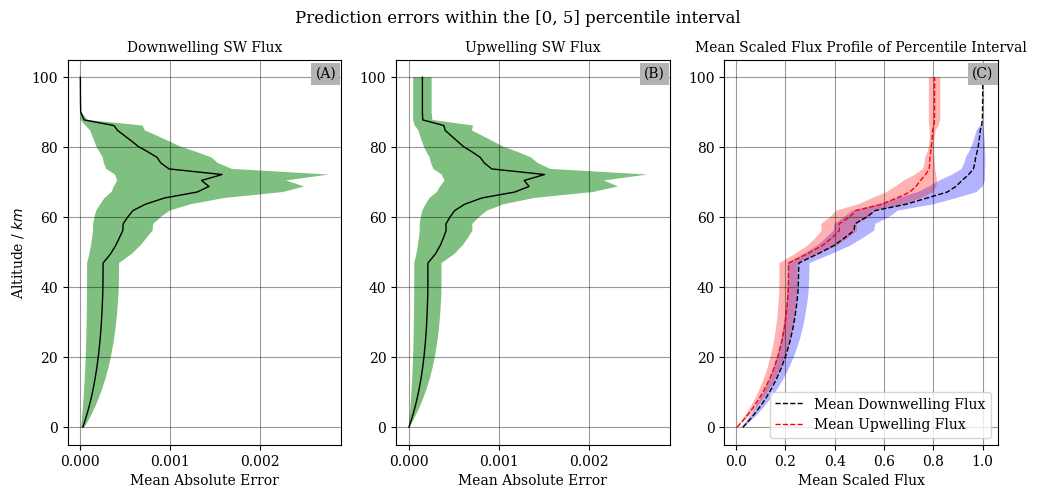

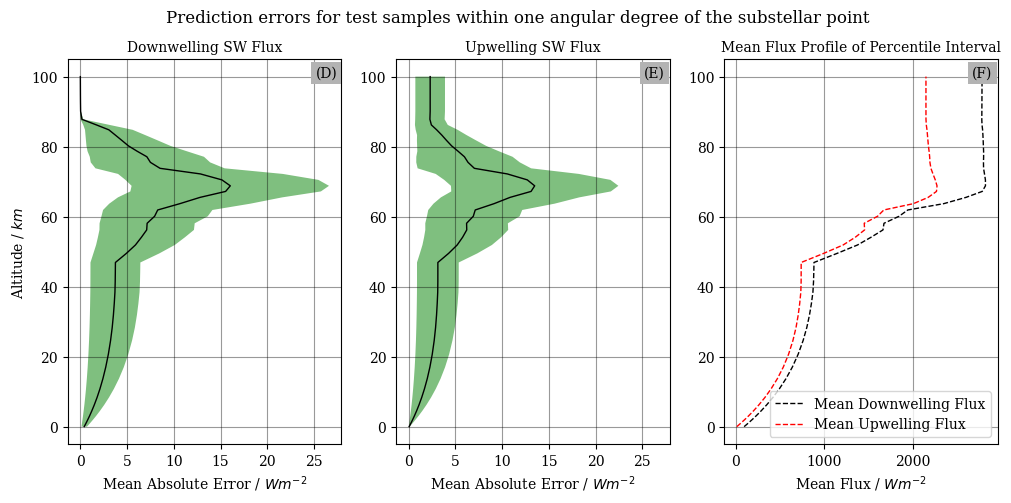

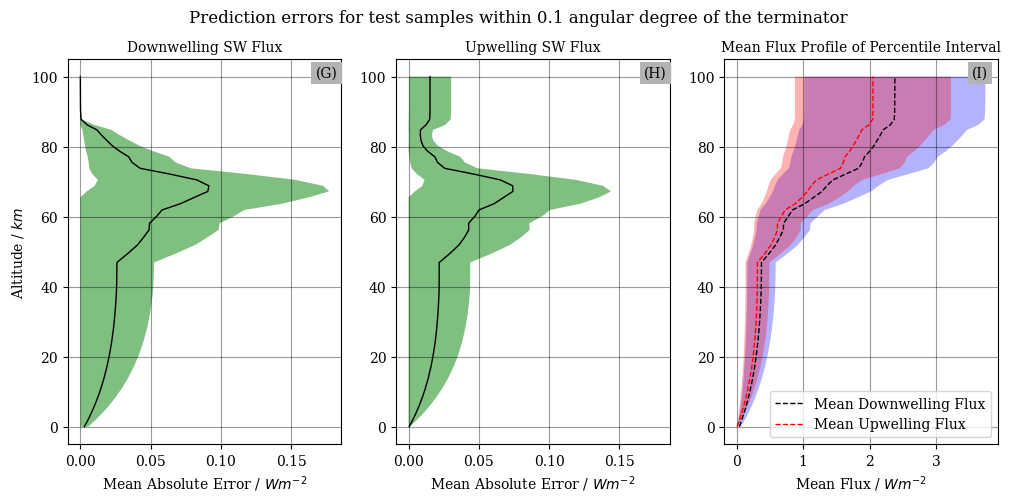

In [239]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey= ax1, sharex = ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey = ax1)
axs = [ax1, ax2, ax3]

for ix, arr in enumerate([down_ae_per_sample, up_ae_per_sample]):

    lower_percentile = 5
    upper_percentile = 95
    lower_bound = np.percentile(arr, lower_percentile)
    upper_bound = np.percentile(arr, upper_percentile)

    mask = (arr>=lower_bound) & (arr<=upper_bound)

    if ix==0:
        masked_abs_error = down_abs_error[mask]
    if ix==1:
        masked_abs_error = up_abs_error[mask]

    lower_lim = np.mean(masked_abs_error, axis=0) - np.std(masked_abs_error, axis=0)
    upper_lim = np.mean(masked_abs_error, axis=0) + np.std(masked_abs_error, axis=0)
    lower_lim[lower_lim<0] = 0

    axs[ix].plot(np.mean(masked_abs_error, axis=0), altitudeh/1000, "k-", linewidth=1)
    axs[ix].fill_betweenx(altitudeh/1000, lower_lim, upper_lim, alpha=0.5, color="g", edgecolor=None)

    axs[0].set_ylabel("Altitude / $km$")
    axs[ix].set_xlabel("Mean Absolute Error")
    axs[ix].set_title(["Downwelling SW Flux", "Upwelling SW Flux"][ix], fontsize=10)
    axs[ix].grid(color='k', alpha=0.4)
    

target_means = np.mean(ytest_ELM[mask], axis=0)
targets_std = np.std(ytest_ELM[mask], axis=0)

axs[2].plot(np.mean(ytest_ELM[mask][:, :, 0], axis=0), altitudeh/1000, "k", linewidth=1, linestyle="dashed", label="Mean Downwelling Flux")
axs[2].fill_betweenx(altitudeh/1000, target_means[:, 0] - targets_std[:, 0], target_means[:, 0] + targets_std[:, 0],alpha=0.3, facecolor="blue", edgecolor="None")
axs[2].plot(np.mean(ytest_ELM[mask][:, :, 1], axis=0), altitudeh/1000, "r", linewidth=1, linestyle="dashed", label="Mean Upwelling Flux")
axs[2].fill_betweenx(altitudeh/1000, target_means[:, 1] - targets_std[:, 1], target_means[:, 1] + targets_std[:, 1], alpha=0.3, facecolor="red", edgecolor="None")
axs[2].legend()
axs[2].set_title("Mean Scaled Flux Profile of Percentile Interval", fontsize=10)
axs[2].set_xlabel("Mean Scaled Flux")
axs[2].grid(color='k', alpha=0.4)

labels = ["(A)","(B)","(C)"]
for ax, label in zip(axs, labels):
    ax.annotate(
            label,
            xy=(0.88, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

del target_means
del targets_std

plt.suptitle(f"Prediction errors within the [{lower_percentile}, {upper_percentile}] percentile interval")

##################################################################################################################

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey= ax1, sharex = ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey = ax1)
axs = [ax1, ax2, ax3]
for ix in range(2):

    mask = test_cosz_ELM>=0.9998476951563915

    if ix==0:
        masked_abs_error = down_abs_error[mask]
    if ix==1:
        masked_abs_error = up_abs_error[mask]

    lower_lim = np.mean(masked_abs_error, axis=0) - np.std(masked_abs_error, axis=0)
    upper_lim = np.mean(masked_abs_error, axis=0) + np.std(masked_abs_error, axis=0)
    lower_lim[lower_lim<0] = 0

    axs[ix].plot(np.mean(masked_abs_error, axis=0), altitudeh/1000, "k-", linewidth=1)
    axs[ix].fill_betweenx(altitudeh/1000, lower_lim, upper_lim, alpha=0.5, color="g", edgecolor=None)

    axs[0].set_ylabel("Altitude / $km$")
    axs[ix].set_xlabel("Mean Absolute Error / $Wm^{-2}$")
    axs[ix].set_title(["Downwelling SW Flux", "Upwelling SW Flux"][ix], fontsize=10)
    axs[ix].grid(color='k', alpha=0.4)
    

target_means = np.mean(postprocessed_targets[mask], axis=0)
targets_std = np.std(postprocessed_targets[mask], axis=0)

axs[2].plot(np.mean(postprocessed_targets[mask][:, :, 0], axis=0), altitudeh/1000, "k", linewidth=1, linestyle="dashed", label="Mean Downwelling Flux")
axs[2].fill_betweenx(altitudeh/1000, target_means[:, 0] - targets_std[:, 0], target_means[:, 0] + targets_std[:, 0],alpha=0.3, facecolor="blue", edgecolor="None")
axs[2].plot(np.mean(postprocessed_targets[mask][:, :, 1], axis=0), altitudeh/1000, "r", linewidth=1, linestyle="dashed", label="Mean Upwelling Flux")
axs[2].fill_betweenx(altitudeh/1000, target_means[:, 1] - targets_std[:, 1], target_means[:, 1] + targets_std[:, 1], alpha=0.3, facecolor="red", edgecolor="None")
axs[2].legend()
axs[2].set_title("Mean Flux Profile of Percentile Interval", fontsize=10)
axs[2].set_xlabel("Mean Flux / $Wm^{-2}$")
axs[2].grid(color='k', alpha=0.4)

labels = ["(D)","(E)","(F)"]
for ax, label in zip(axs, labels):
    ax.annotate(
            label,
            xy=(0.88, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

del target_means
del targets_std

##################################################################################################################

plt.suptitle(f"Prediction errors for test samples within one angular degree of the substellar point")

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey= ax1, sharex = ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey = ax1)
axs = [ax1, ax2, ax3]
for ix, arr in enumerate([down_ae_per_sample, up_ae_per_sample]):

    mask = test_cosz_ELM<=degrees_to_radians(0.1)

    if ix==0:
        masked_abs_error = down_abs_error[mask]
    if ix==1:
        masked_abs_error = up_abs_error[mask]

    lower_lim = np.mean(masked_abs_error, axis=0) - np.std(masked_abs_error, axis=0)
    upper_lim = np.mean(masked_abs_error, axis=0) + np.std(masked_abs_error, axis=0)
    lower_lim[lower_lim<0] = 0

    axs[ix].plot(np.mean(masked_abs_error, axis=0), altitudeh/1000, "k-", linewidth=1)
    axs[ix].fill_betweenx(altitudeh/1000, lower_lim, upper_lim, alpha=0.5, color="g", edgecolor=None)

    axs[0].set_ylabel("Altitude / $km$")
    axs[ix].set_xlabel("Mean Absolute Error / $Wm^{-2}$")
    axs[ix].set_title(["Downwelling SW Flux", "Upwelling SW Flux"][ix], fontsize=10)
    axs[ix].grid(color='k', alpha=0.4)
    

target_means = np.mean(postprocessed_targets[mask], axis=0)
targets_std = np.std(postprocessed_targets[mask], axis=0)

axs[2].plot(np.mean(postprocessed_targets[mask][:, :, 0], axis=0), altitudeh/1000, "k", linewidth=1, linestyle="dashed", label="Mean Downwelling Flux")
axs[2].fill_betweenx(altitudeh/1000, target_means[:, 0] - targets_std[:, 0], target_means[:, 0] + targets_std[:, 0],alpha=0.3, facecolor="blue", edgecolor="None")
axs[2].plot(np.mean(postprocessed_targets[mask][:, :, 1], axis=0), altitudeh/1000, "r", linewidth=1, linestyle="dashed", label="Mean Upwelling Flux")
axs[2].fill_betweenx(altitudeh/1000, target_means[:, 1] - targets_std[:, 1], target_means[:, 1] + targets_std[:, 1], alpha=0.3, facecolor="red", edgecolor="None")
axs[2].legend()
axs[2].set_title("Mean Flux Profile of Percentile Interval", fontsize=10)
axs[2].set_xlabel("Mean Flux / $Wm^{-2}$")
axs[2].grid(color='k', alpha=0.4)

labels = ["(G)","(H)","(I)"]
for ax, label in zip(axs, labels):
    ax.annotate(
            label,
            xy=(0.88, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

del target_means
del targets_std

plt.suptitle(f"Prediction errors for test samples within 0.1 angular degree of the terminator")

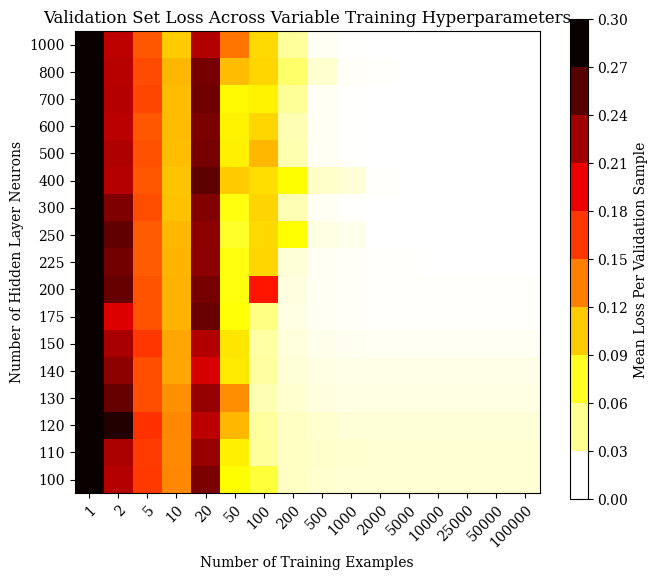

In [309]:
fig, ax = plt.subplots(figsize=(6,6))

# Define colormap
cmap = plt.cm.hot_r  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
vmax, vmin = 0.3, 0
bounds = np.linspace(vmin*100, vmax*100, 11) / 100
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create heatmap
cax = ax.imshow(grid_losses[2, :, :].T/num_val_samples, cmap=cmap, interpolation='nearest', aspect='auto', origin="lower")#, norm=LogNorm())

# Add colorbar
ax1 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='vertical',
    spacing='proportional', ticks=bounds, boundaries=bounds)
cb.set_label("Mean Loss Per Validation Sample")
ax.set_xlabel('Number of Training Examples')
ax.set_ylabel('Number of Hidden Layer Neurons')

# Set title
ax.set_title('Validation Set Loss Across Variable Training Hyperparameters')

# Customizing ticks
ax.set_xticks(np.arange(grid_losses[2, :, :].T.shape[1]))
ax.set_yticks(np.arange(grid_losses[2, :, :].T.shape[0]))
ax.set_yticklabels([f'{i}' for i in number_neurons])
ax.set_xticklabels([f'{i}' for i in number_training_examples])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

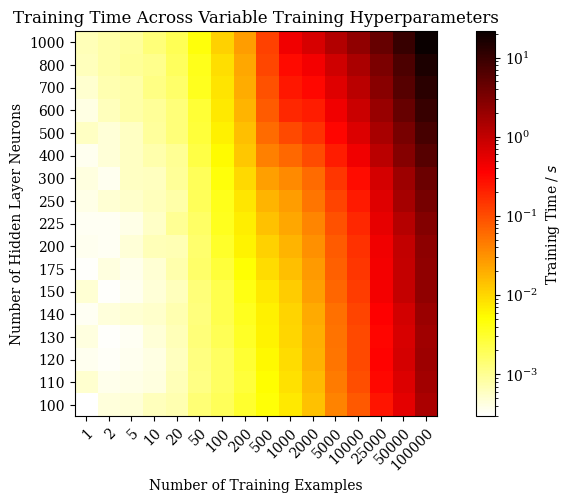

In [204]:
fig, ax = plt.subplots(figsize=(10, 5))

# Create the heatmap
cax = ax.imshow(grid_losses[0, :, :].T, cmap=plt.cm.hot_r , interpolation='nearest', norm=LogNorm(), origin='lower')

# Add colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', spacing="proportional", fraction=0.05, location='right')
cbar.set_label("Training Time / $s$")

# Set axis labels
ax.set_xlabel('Number of Training Examples')
ax.set_ylabel('Number of Hidden Layer Neurons')

# Set title
ax.set_title('Training Time Across Variable Training Hyperparameters')

# Customizing ticks
ax.set_xticks(np.arange(grid_losses[0, :, :].T.shape[1]))
ax.set_yticks(np.arange(grid_losses[0, :, :].T.shape[0]))
ax.set_yticklabels([f'{i}' for i in number_neurons])
ax.set_xticklabels([f'{i}' for i in number_training_examples])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

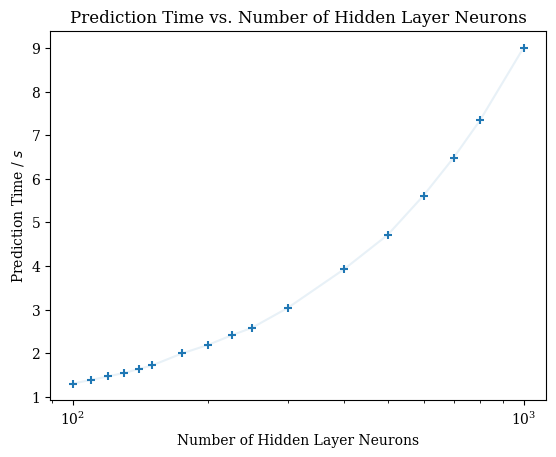

In [217]:
plt.scatter(number_neurons[:], np.mean(grid_losses_3[1, :, :], axis=0), marker="+")
plt.plot(number_neurons[:], np.mean(grid_losses_3[1, :, :], axis=0), alpha=0.1)
plt.xscale('log')
plt.xlabel("Number of Hidden Layer Neurons")
plt.ylabel("Prediction Time / $s$")
plt.title("Prediction Time vs. Number of Hidden Layer Neurons")
plt.show()

### Effect of Different Random Seeds for Grid-Optimised Network

In [ ]:
# Create list of seeds
seeds = list(range(25))

# Save params of grid-optimised model
hidden_size = number_neurons[best_idx[1]]
num_train_samples = number_training_examples[best_idx[0]]
with open(os.path.join(ELM_savepath, 'best_model_params.txt'), 'w') as f:
    f.write(f"number_training_examples: {num_train_samples}")
    f.write(f"\nnumber_neurons: {hidden_size}")

# Define training input and target sets
X_ = train_x[:num_train_samples, :, :].reshape(num_train_samples, 49 * 3)
y_ = train_y[:num_train_samples, :, :].reshape(num_train_samples, 50 * 2)

# Initialise results arrays
grid_losses_random_seeds = np.zeros(shape=(len(seeds),))
grid_mae_random_seeds = np.zeros(shape=(len(seeds), 50, 2))
grid_vae_random_seeds = np.zeros(shape=(len(seeds), 50, 2))

# Perform grid search
for ix, seed in enumerate(seeds):
    print(seed)
    elm = ELM(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        activation_function="relu",
        random_seed=seed
    )
    training_start_time = time.time()
    elm.fit(X_, y_)
    training_end_time = time.time()

    prediction_start_time = time.time()
    ypred_ = elm.predict(val_x)
    prediction_end_time = time.time()

    ypred_ = ypred_.reshape((num_val_samples, 50, 2))
    mae, vae, loss = metrics(ypred_, val_y)

    grid_losses_random_seeds[ix] = loss
    grid_mae_random_seeds[ix, :, :] = mae
    grid_vae_random_seeds[ix, :, :] = vae

# Save results of grid search
with open(os.path.join(ELM_savepath, 'grid_mae_random_seeds.npy'), 'wb') as f:
    np.save(f, grid_mae_random_seeds)
with open(os.path.join(ELM_savepath, 'grid_vae_random_seeds.npy'), 'wb') as f:
    np.save(f, grid_vae_random_seeds)
with open(os.path.join(ELM_savepath, 'grid_losses_random_seeds.npy'), 'wb') as f:
    np.save(f, grid_losses_random_seeds)

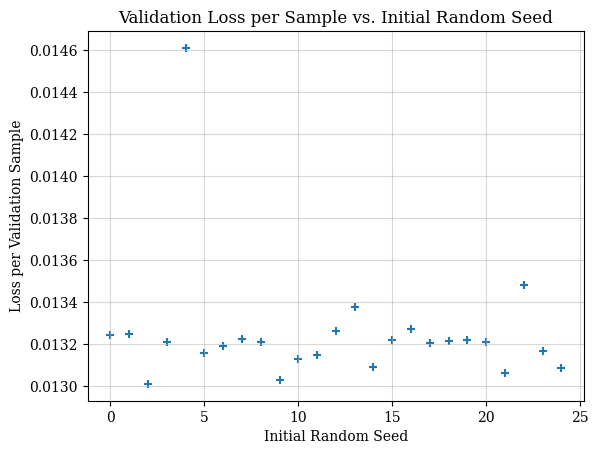

In [262]:
plt.scatter(seeds, grid_losses_random_seeds/num_val_samples, marker="+")
plt.xlabel("Initial Random Seed")
plt.ylabel("Loss per Validation Sample")
plt.title("Validation Loss per Sample vs. Initial Random Seed")
plt.grid(alpha=0.5)
plt.show()

## **RNN**

### Load Model

In [18]:
import tensorflow as tf
from main import load_and_compile_model, make_predictions, SW_MODEL_PATH

# Load model
rnn = load_and_compile_model(SW_MODEL_PATH)

prediction_start_time = time.time()
rnn_preds = make_predictions(rnn, tf.convert_to_tensor(sample_test_x), tf.convert_to_tensor(sample_test_aux_x))
prediction_end_time = time.time()

print("Time to make", num_samples, "predictions: ", np.round(prediction_end_time - prediction_start_time, 2), "s")

1/1 [==============================] - 25s 25s/step
Time to make 50000 predictions:  41.78 s


In [35]:
41.78 / 0.81

51.58024691358025

## **Time Predictions (on CPU)**

In [ ]:
sample_sizes = [1, 10, 100, 1000, 10000, 50000, 100000]
nrepeats = 5
with open(os.path.join(ELM_savepath, 'prediction_times_sample_sizes.txt'), 'w') as f:
    f.write(f"sample_sizes: {sample_sizes}")
    f.write(f"nrepeats: {nrepeats}")

# Specify number of times to repeat

times = np.zeros((2, nrepeats, len(sample_sizes)))

for ix, sample_size in enumerate(sample_sizes):

    sample_test_x = test_x[:sample_size, :, :]
    sample_test_aux_x = test_aux_x[:sample_size, :]
    sample_test_y = test_y[:sample_size, :, :]

    # Time RNN
    for r in range(nrepeats):
        rnn_start_time = time.time()
        rnn_preds = make_predictions(rnn, tf.convert_to_tensor(sample_test_x), tf.convert_to_tensor(sample_test_aux_x))
        rnn_end_time = time.time()

        times[0, r, ix] = rnn_end_time - rnn_start_time

    # Time ELM
    for r in range(nrepeats):
        elm_start_time = time.time()
        elm_preds = elm.predict(sample_test_x.reshape(sample_test_x.shape[0], input_size))
        elm_end_time = time.time()

        times[1, r, ix] = elm_end_time - elm_start_time

with open(os.path.join(ELM_savepath, "prediction_times.npy"), "wb") as f:
    np.save(f, times)


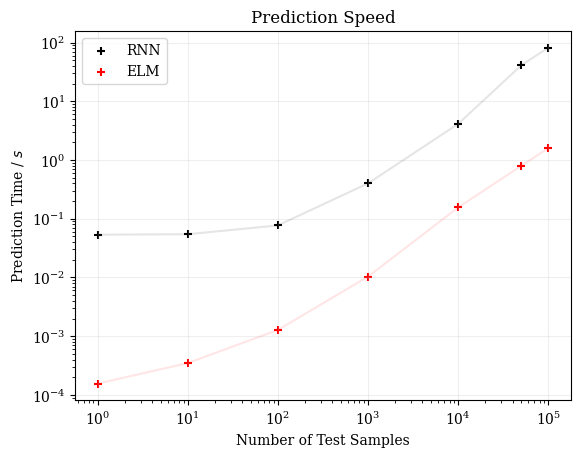

In [68]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})

plt.scatter(sample_sizes, np.mean(times[0, :, :], axis=0), color="k", label="RNN", marker="+")
plt.scatter(sample_sizes, np.mean(times[1, :, :], axis=0), color="r", label="ELM", marker="+")
plt.plot(sample_sizes, np.mean(times[0, :, :], axis=0), color="k", alpha=0.1)
plt.plot(sample_sizes, np.mean(times[1, :, :], axis=0), color="r", alpha=0.1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Test Samples")
plt.ylabel("Prediction Time / $s$")
plt.title("Prediction Speed")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

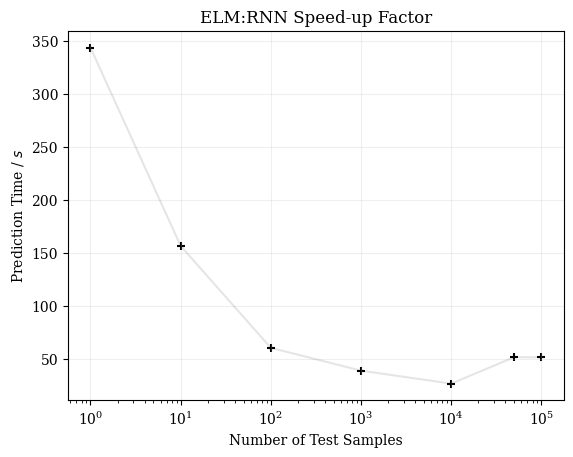

In [70]:
plt.scatter(sample_sizes, np.mean(times[0, :, :], axis=0) / np.mean(times[1, :, :], axis=0), color="k", marker="+")
plt.plot(sample_sizes, np.mean(times[0, :, :], axis=0) / np.mean(times[1, :, :], axis=0), color="k", alpha=0.1)
# plt.scatter(sample_sizes, np.mean(times[1, :, :], axis=0), color="r", label="ELM", marker="+")
# plt.plot(sample_sizes, np.mean(times[0, :, :], axis=0), color="k", alpha=0.1)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Number of Test Samples")
plt.ylabel("Prediction Time / $s$")
plt.title("ELM:RNN Speed-up Factor")
plt.grid(alpha=0.2)
plt.show()

## **Training Time**

In [76]:
print("Training Time for Grid-Optimised Predictor: ", np.round(grid_losses[0, :, :][best_idx], 2), "s")

Training Time for Grid-Optimised Predictor:  2.25 s


## **Accuracy**

### 1. RNN

In [83]:
# Load test predictions

rnn_test_preds_path = "/home/ucaptp0/oasis-rt-surrogate/analysis/trained-models/predictions/predictions-649968.npy"
with open(rnn_test_preds_path, "rb") as f:
    rnn_test_preds = np.load(f)

### 2. ELM

In [79]:
# Generate ELM predictions

elm_test_preds = elm.predict(test_x.reshape(num_test_samples, input_size))
elm_test_preds = elm_test_preds.reshape(num_test_samples, 50, 2)

In [89]:
def MAE(ypred, ytrue):
    return np.mean(np.sum(np.abs(ypred - ytrue), axis=1) / np.sum(np.abs(ytrue), axis=1), axis=0)

mae_rnn = MAE(rnn_test_preds, test_y)
mae_elm = MAE(elm_test_preds, test_y)

print("ELM: ", mae_elm)
print("RNN: ", mae_rnn)

print("RNN/ELM Error Ratio: ", mae_elm / mae_rnn)

ELM:  [0.00636016 0.00678567]
RNN:  [0.0141338  0.01415624]
RNN/ELM Error Ratio:  [0.4499967  0.47934173]
